In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.81 MiB | 33.11 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [0]:
# !unzip /content/customdataset.zip

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !mv custom.py Mask_RCNN/
!cp '/content/drive/My Drive/Colab Notebooks/Sem 3_Advanced CV/custom.py' '/content/Mask_RCNN'

In [6]:
%cd Mask_RCNN/

/content/Mask_RCNN


In [0]:
!mkdir train_logs

In [8]:
!python3 custom.py train --dataset='/content/drive/My Drive/Colab Notebooks/Sem 3_Advanced CV/customdataset' --weights=coco --logs=/content/Mask_RCNN/train_logs/

Using TensorFlow backend.
Weights:  coco
Dataset:  /content/drive/My Drive/Colab Notebooks/Sem 3_Advanced CV/customdataset
Logs:  /content/Mask_RCNN/train_logs/

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class

In [9]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
# Root directory of the project
ROOT_DIR = os.getcwd()
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import custom
%matplotlib inline
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "train_logs/damage20191117T1608")
custom_WEIGHTS_PATH = "mask_rcnn_damage_0003.h5"  # TODO: update this path

Using TensorFlow backend.


In [10]:
config = custom.CustomConfig()
custom_DIR = '/content/drive/My Drive/Colab Notebooks/Sem 3_Advanced CV/customdataset'
class InferenceConfig(config.__class__):
   # Run detection on one image at a time
   GPU_COUNT = 1
   IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Images: 15
Classes: ['BG', 'damage']







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  mask_rcnn_damage_0003.h5






Re-starting from epoch 3
image ID: damage.image74.jpeg (7) /content/drive/My Drive/Colab Notebooks/Sem 3_Advanced CV/customdataset/val/image74.jpeg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


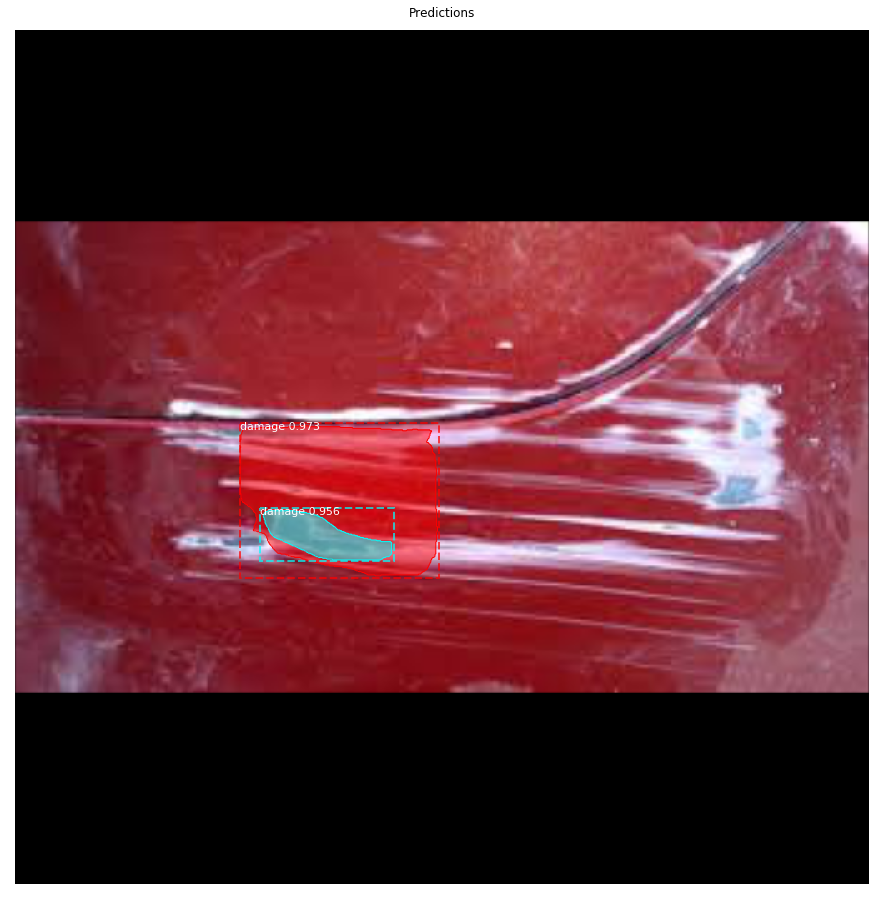

In [11]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
   """Return a Matplotlib Axes array to be used in
   all visualizations in the notebook. Provide a
   central point to control graph sizes.
   Adjust the size attribute to control how big to render images
   """
   _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
   return ax
# Load validation dataset
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "val")
# Must call before using the dataset
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
# Create model in inference mode
with tf.device(DEVICE):
   model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                             config=config)
# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(MODEL_DIR+'/'+custom_WEIGHTS_PATH, by_name=True)
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
   modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                      dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                           dataset.class_names, r['scores'], ax=ax,
                           title="Predictions")